In [1]:
import bs4 as bs
import pandas as pd
import os
import pandas_datareader.data as web
import pickle
import requests
from dateutil.relativedelta import relativedelta, FR
import numpy as np

In [2]:
end_date = pd.Timestamp(pd.to_datetime('today').strftime("%m/%d/%Y"))
start_date = end_date - relativedelta(years=10)

In [3]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text[:-1]
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers

In [4]:
def get_data_from_yahoo(start_date, end_date, reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = start_date
    end = end_date
    for ticker in tickers:
        # just in case your connection breaks, we'd like to save our progress!
        ticker = ticker.replace('.', '-')
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.reset_index(inplace=True)
                df.set_index("Date", inplace=True)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
                print('Create {}'.format(ticker))
            except:
                print('Drop {}'.format(ticker))
                pass
        else:
            print('Already have {}'.format(ticker))

In [5]:
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        try:
            df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
            df["Name"] = ticker
            df.set_index('Date', inplace=True)
            df.drop(['Adj Close'], axis = 1)

            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.append(df)
        except:
            pass

        if count % 100 == 0:
            print(count)

    print(main_df.head())
    main_df.to_csv('all_stocks_10yr.csv')


In [6]:
get_data_from_yahoo(start_date, end_date, reload_sp500=True)
compile_data()

Create MMM
Create ABT
Create ABBV
Create ABMD
Create ACN
Create ATVI
Create ADBE
Create AMD
Create AAP
Create AES
Create AFL
Create A
Create APD
Create AKAM
Create ALK
Create ALB
Create ARE
Create ALXN
Create ALGN
Create ALLE
Create LNT
Create ALL
Create GOOGL
Create GOOG
Create MO
Create AMZN
Create AMCR
Create AEE
Create AAL
Create AEP
Create AXP
Create AIG
Create AMT
Create AWK
Create AMP
Create ABC
Create AME
Create AMGN
Create APH
Create ADI
Create ANSS
Create ANTM
Create AON
Create AOS
Create APA
Create AAPL
Create AMAT
Create APTV
Create ADM
Create ANET
Create AJG
Create AIZ
Create T
Create ATO
Create ADSK
Create ADP
Create AZO
Create AVB
Create AVY
Create BKR
Create BLL
Create BAC
Create BK
Create BAX
Create BDX
Create BRK-B
Create BBY
Create BIO
Create BIIB
Create BLK
Create BA
Create BKNG
Create BWA
Create BXP
Create BSX
Create BMY
Create AVGO
Create BR
Create BF-B
Create CHRW
Create COG
Create CDNS
Create CZR
Create CPB
Create COF
Create CAH
Create KMX
Create CCL
Create CARR

In [7]:
def inputvec(data, company, year):
    
    '''
    takes the relevant info from data (company is a string, year is an int)
    generates a 4D vector Q_{i} for the ith quarter
    
    Q_{i} elements:
        v_{i}: standard deviation of opening price
        s_{i}: mean(high price - low price)
        n_{y,i}: mean(traded shares)
        h_{y,i}: mean(high price)
    
    output is concatenation of company, year, Q_{1}, Q_{2}, Q_{3}, and Q_{4}
    '''

    #filters out by the company and relevant year
    filter1 = data.loc[data['Name'] == company]
    filter2 = filter1.loc[filter1['Date'].str.contains(str(year))]
    
    def Q(i):
        
        if i == 1:
            
            month_strs = ['-01-', '-02-', '-03-']
            
        if i == 2:
            
            month_strs = ['-04-', '-05-', '-06-']
            
        if i == 3:
            
            month_strs = ['-07-', '-08-', '-09-']
            
        if i == 4:
            
            month_strs = ['-10-', '-11-', '-12-']
        
        filterquarter = filter2
        months = [filterquarter.loc[filterquarter['Date'].str.contains(month_str)] for month_str in month_strs]
    
        opens = [month['Open'].tolist() for month in months] 
        opens = [j for i in opens for j in i] #concatenates months
        
        highs = [month['High'].tolist() for month in months]
        highs = [j for i in highs for j in i]
        
        lows = [month['Low'].tolist() for month in months]
        lows = [j for i in lows for j in i]
        
        volumes = [month['Volume'].tolist() for month in months]
        volumes = [j for i in volumes for j in i]
        
        spreads = [highs[i] - lows[i] for i in range(len(highs))]
        
        #ignores NaNs
        
        if len(opens) != 0: #checking if there's actually any data
            mo, mh, ml, mv, ms = max(opens), max(highs), max(lows), max(volumes), max(spreads)
            try:
                opens = [opening/mo for opening in opens]
                highs = [high/mh for high in highs]
                lows = [low/ml for low in lows]
                volumes = [volume/mv for volume in volumes]
                spreads = [spread/ms for spread in spreads]

            except:
                pass
            v, s = np.nanstd(opens), np.nanmean(spreads)
            n, h = np.nanmean(volumes), np.nanmean(highs)
    
        else:
            v, s, n, h = 'nan', 'nan', 'nan', 'nan'
    
        return [v, s, n, h]

    return [company, year] + Q(1) + Q(2) + Q(3) + Q(4)

In [8]:
raw = pd.read_csv('all_stocks_10yr.csv')
data = raw.loc[:, ('Date','Open','High','Low','Close','Volume','Name')]

companies = data.Name.unique()
years = ['2011', '2012','2013', '2014', '2015', '2016', '2017','2018', '2019', '2020', '2021']

In [9]:
#list comprehension to get input vectors for each company in each year
inputvecs = [inputvec(data, company, year) for company in companies for year in years]

In [10]:
with open('inputvector_table.txt', 'w+') as f:
            for item in inputvecs:
                if 'nan' not in tuple(item): #doesn't write in vectors with insufficient data
                    f.write('%s %s %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f %.02f\n'%(tuple(item)))


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

In [12]:
    def PerformOperation():
        #load and prepare data
        input_vecs = np.array(pd.read_csv("inputvector_table.txt", sep =" ", header =None))
        vectors = input_vecs[:,2:]
        labels = input_vecs[:,:2]
        
        vectors = np.asarray(vectors).astype('float32')
        
        x_train, x_test, y_train, y_test = train_test_split(vectors, labels, test_size=0.33, random_state=1)
        
        x_train = np.asarray(x_train).astype('float32')
        x_test = np.asarray(x_test).astype('float32')
        
        #Setup autoencoder structure
        input_vector = Input(shape=(16,)) #Use 16 floats vector as input
        encoded_1 = Dense(500, activation='selu')(input_vector)
        encoded_2 = Dense(250, activation='selu')(encoded_1)
        middle_layer = Dense(2, activation='elu')(encoded_2)
        decoded_1 = Dense(250, activation='selu')(middle_layer)
        decoded_2 = Dense(500, activation='selu')(decoded_1)
        decoded_output = Dense(16, activation='sigmoid')(decoded_2)
        
        
        autoencoder = Model(input_vector, decoded_output)
        autoencoder.compile(optimizer='rmsprop', loss='mae')
        autoencoder.summary()
        
        #Train the autoencoder
        autoencoder.fit(x_train, x_train,
                        epochs=30, #also used many different epoch values/batch sizes
                        batch_size=4,
                        shuffle=True,
                        validation_data=(x_test, x_test))
        
        autofitted = autoencoder.predict(vectors)
        
        #compare to estimate performance
        autofitted[1]
        x_test[1]
        
        #separate encoder
        encoder = Model(input_vector, middle_layer)
        encoder.compile(optimizer='rmsprop', loss='mae')
        
        #predict encoded vectors from input vectors
        encoded_vecs = encoder.predict(vectors)
        
        #separate decoder
        encoded_vector = Input(shape=(2,))
        deco1 = autoencoder.layers[-3](encoded_vector)
        deco2 = autoencoder.layers[-2](deco1)
        decoout = autoencoder.layers[-1](deco2)
        decoder = Model(encoded_vector, decoout)
        
        #predict decoded vectors from encoded vectors
        decoded_vecs = decoder.predict(encoded_vecs)
        
        #Confirm that separate encoding/decoding does the same as the autoencoder
        np.array_equal(autofitted, decoded_vecs)
        
        #Write labels with corresponding encoded values to file
        output = np.concatenate((labels,encoded_vecs), axis=1)
        np.savetxt("encoded_with_labels.txt", output, fmt='%s', delimiter=',')


In [13]:
PerformOperation()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 500)               8500      
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 502       
_________________________________________________________________
dense_3 (Dense)              (None, 250)               750       
_________________________________________________________________
dense_4 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                8016  

In [14]:
def PlotKmeans(encoded_values,y_kmeans,centers, n ):
        plt.figure()
        plt.scatter(encoded_values[:, 0], encoded_values[:, 1], c=y_kmeans, s=5, cmap='Dark2')
        plt.scatter(centers[:, 0], centers[:, 1], s=20, c='red')
        #plt.text(encoded_values[:, 0], encoded_values[:, 1], labels, fontsize=8)
        plt.xlabel(r'$x$', fontsize=16)
        plt.ylabel(r'$y$', fontsize=16)
        plt.title(r'$k$-means, $N_{clusters} = %i$'%n, fontsize=16)
        plt.show()

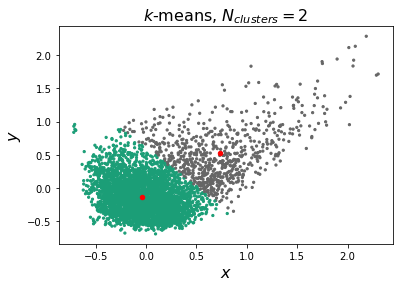

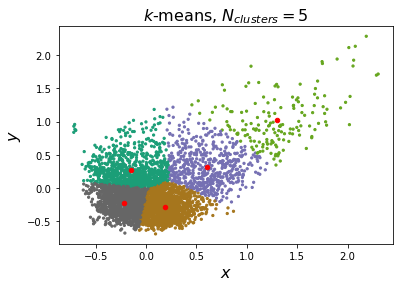

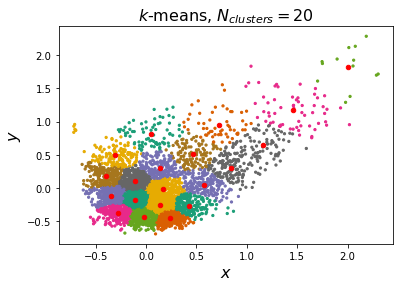

In [32]:
        #load and prepare data for K-means
encodedData = np.array(pd.read_csv('encoded_with_labels.txt', sep = ',', header=None))
encoded_values = encodedData[:,2:4]
        
ns = [2, 5, 20]
        
for n in ns:

    #apply kmeans clustering and plot
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(encoded_values)
    y_kmeans = kmeans.predict(encoded_values)
    centers = kmeans.cluster_centers_   
    PlotKmeans(encoded_values,y_kmeans,centers, n )

In [33]:
def plot_gmm(firstvar, secondvar, labels, name):
    X = np.vstack([firstvar, secondvar]).T # GaussianMixture requires a 2D array as input
    
    K = np.arange(1, 6)
    models = [None for i in K]
    
    models = [GaussianMixture(K[i], random_state=1, covariance_type='full', \
              n_init=10).fit(X) for i in range(len(K))]
    
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    logL = [m.score(X) for m in models]
    for i in range(len(K)):
        print('K = %d  AIC = %.1f  BIC = %.1f  logL = %.3f'%(K[i], AIC[i], BIC[i], logL[i]))
    
    gmm_best = models[np.argmin(AIC)] # choose the best model with smallest AIC
    
    print('mu =', gmm_best.means_.flatten())
    print('sig =', np.sqrt(gmm_best.covariances_.flatten()))
    print('pk =', gmm_best.weights_.flatten())
    
    plt.figure()
    
    plt.scatter(firstvar, secondvar, s=2)
    plt.xlabel(r'$x$', fontsize=20)
    plt.ylabel(r'$y$', fontsize=20)
    plt.title('Gaussian Mixture Model, %s'%(name), fontsize=14)
    plt.tight_layout()
    
    for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
        draw_ellipse(mu, C, scales=[2], fc='none', ec='k')
        
    if name == 'bigtech':
        for i in range(len(firstvar)):
            plt.text(firstvar[i], secondvar[i], labels[i], color="red", fontsize=4)
    plt.show()
    
    return gmm_best

In [34]:
data = pd.read_csv('encoded_with_labels.txt')

data.columns= ['company', 'year', 'x', 'y']

company = data['company'].tolist()
year = data['year'].tolist()

l = [company[i] + ', ' + str(year[i]) for i in range(len(company))]
x = data['x'].tolist()
y = data['y'].tolist()

bigtech_companies = ['AMZN', 'GOOGL', 'AAPL', 'ORCL', 'MSFT', 'FB', 'IBM']
data_justtech = data.loc[data['company'].isin(bigtech_companies)]

company_bigtech = data_justtech['company'].tolist()
year_bigtech = data_justtech['year'].tolist()

l_bt = [company_bigtech[i] + ', ' + str(year_bigtech[i]) for i in range(len(company_bigtech))]
x_bt = data_justtech['x'].tolist()
y_bt = data_justtech['y'].tolist()

K = 1  AIC = 7667.7  BIC = 7699.6  logL = -0.874
K = 2  AIC = 5373.4  BIC = 5443.7  logL = -0.611
K = 3  AIC = 5089.4  BIC = 5197.9  logL = -0.577
K = 4  AIC = 4921.2  BIC = 5068.0  logL = -0.557
K = 5  AIC = 4863.6  BIC = 5048.7  logL = -0.549
mu = [-0.20069862 -0.21544203  1.18475146  0.84156998  0.16951891 -0.28848477
 -0.12029224  0.17436308  0.53222467  0.30356355]
sig = [0.15345112        nan        nan 0.17993416 0.40869493 0.36168
 0.36168    0.47777851 0.16021447 0.02842403 0.02842403 0.16942387
 0.23299181        nan        nan 0.2578948  0.26705022        nan
        nan 0.33532493]
pk = [0.30622896 0.04527383 0.29176822 0.22068284 0.13604615]


<ipython-input-33-dcef5fb99b80>:19: RuntimeWarning: invalid value encountered in sqrt
  print('sig =', np.sqrt(gmm_best.covariances_.flatten()))


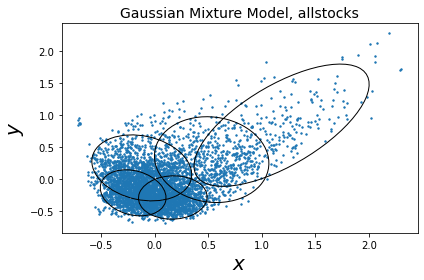

In [35]:
models = plot_gmm(x,y,l,'allstocks')
#plot_gmm(x_bt,y_bt,l_bt,'bigtech')

In [31]:


np.savetxt("output.txt", models.predict_proba(encoded_values), fmt='%s', delimiter=',')

array(['MMM', 'MMM', 'MMM', ..., 'ZTS', 'ZTS', 'ZTS'], dtype=object)